In [1]:
# NO CHANGE
from chirho_diffeqpy import DiffEqPy, ATempParams
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide
from collections import namedtuple
from chirho.observational.handlers import condition
from itertools import product
from toy_fish.handlers import VirtualFishContext
from toy_fish.ops import sin, cos, NoVirtualFish, virtual_fish_dynamics
from collections import namedtuple

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(82901)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
Precompiling DifferentialEquations
  ✓ LinearSolve → LinearSolveFastAlmostBandedMatricesExt
  ✓ NonlinearSolve → NonlinearSolveBandedMatricesExt
  ✓ DelayDiffEq
  ✓ StochasticDiffEq
  ✓ BoundaryValueDiffEq
  ✓ BoundaryValueDiffEq → BoundaryValueDiffEqOrdinaryDiffEqExt
  ✓ DifferentialEquations
  7 dependencies successfully precompiled in 87 seconds. 255 already precompiled.
[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
Precompiling ModelingToolkit
  ✓ ModelingToolkit
  1 dependency successfully precompiled in 115 seconds. 256 already precompiled.
[ Info: Precompiling ModelingToolkit [961ee093-0014-501f-94e3-6117800e7a78]
┌ Warning: Module OrdinaryDiffEq with build ID fafbfcfd-4dc4-dd59-0000-5a8890d0054a is missing from the cache.
│ This may mean OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
/

# System Definition

### General, Multi-Fish System Dynamics

In [2]:
# NO CHANGE
def pure_schooling_dynamics(state, atemp_params):
    thetas = state['thetas']
    
    # If this is being run in the experimental context of a virtual fish,
    #  compute the virtual fish dynamics and distance to real fish.
    try:
        # ...if the virtual fish is present.
        ddt_vfish = virtual_fish_dynamics(state, atemp_params)
        vfish_theta = state['vfish_theta']
        virtual_fish_diff = vfish_theta - thetas
    except NoVirtualFish:
        # ...otherwise proceed with no virtual fish.
        ddt_vfish = dict()
        virtual_fish_diff = 0.0
    
    # Compute the distances between the real fish and virtual fish.
    thetas_diff_mat = thetas[..., :, None] - thetas[..., None, :]
    thetas_diff_tots = thetas_diff_mat.sum(axis=-2) + virtual_fish_diff
    assert thetas.shape == thetas_diff_tots.shape
    
    # And the resulting dynamics.
    copy_coefs = atemp_params['copy_coefs']
    dthetas = thetas_diff_tots * copy_coefs
    
    return dict(
        thetas=dthetas,
        **ddt_vfish
    )

### Virtual Fish Definitions

In [3]:
# NO CHANGE
def sinusoidal_virtual_fish(state, atemp_params):
    
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    phase = atemp_params['phase']
    t = state['t']
    
    return dict(
        vfish_theta=amplitude * frequency * cos(frequency * t + phase)
    )

### Low Level, Default Experimental Model

In [4]:
# NO CHANGE
START_T = torch.tensor(0.0)
END_T = torch.tensor(5.0)
RES = 50
GET_TRUE_COPY_COEFS = lambda: torch.tensor([3., 1.])

def run_experiment(logging_times, initial_state, atemp_params):
    with LogTrajectory(times=logging_times) as logging_trajectory:
        simulate(
            pure_schooling_dynamics,
            initial_state,
            START_T,
            END_T,
            atemp_params=atemp_params
        )
    return logging_trajectory.trajectory

### Mesoscopic Observations

In [5]:
# NO CHANGE
def polarization_fn(theta):
    theta = theta.T
    assert theta.shape[-1] == 2, "Multi-fish polarization is not yet implemented!"
    return torch.sqrt((1 + torch.cos(theta[...,0] - theta[...,1]))/2)

### Mesoscopic Experimental Model

In [6]:
# NO CHANGE
SOLVER = DiffEqPy()

In [7]:
# NO CHANGE
def copy_coefficient_prior(num_fish: int):
    return sample("copy_coefs", dist.Uniform(0., 10.).expand((num_fish,)).to_event(1))

def mesoscopic_experiment_model(
    num_fish: int,
    mesoscopioc_noise: float,
    experimental_context = None,
    copy_coefs = None,
    initial_state = None,
):
    
    if experimental_context is None:
        experimental_context = nullcontext()
    
    if copy_coefs is None:
        copy_coefs = copy_coefficient_prior(num_fish)
    
    if initial_state is None:
        initial_state = dict(
            thetas=torch.linspace(0., torch.pi, num_fish)
        )
    
    fixed_observation_times = torch.linspace(START_T, END_T, RES)
    
    with SOLVER, experimental_context:
        trajectory = run_experiment(
            logging_times=fixed_observation_times,
            initial_state=initial_state,
            atemp_params=dict(
                copy_coefs=copy_coefs
            )
        )
        
        polarization = polarization_fn(trajectory['thetas'])
        # A trivial noise model over the polarization. This largely functions to relax the problem for inference.
        observed_polarization = pyro.sample("polarization", dist.Normal(polarization, mesoscopioc_noise).to_event(1))
        
        return trajectory, observed_polarization

### Experimental Contexts

In [8]:
# NO CHANGE
# Default experimental context
no_vfish = nullcontext()

# Simple sinusoidal virtual fish.
exemplar_sinusoid_vfish = VirtualFishContext(
    sinusoidal_virtual_fish,
    initial_state=dict(
        vfish_theta=torch.tensor(0.0)
    ),
    atemp_params=dict(
        frequency=torch.tensor(1.),
        amplitude=torch.tensor(torch.pi),
        phase=torch.tensor(0.)
    )
)

In [9]:
# TODO add 3, 1/1, 3 non-identification example here

LOW_NOISE = 0.00001

low_noise_experiment = partial(
    mesoscopic_experiment_model,
    num_fish=2,
    mesoscopioc_noise=LOW_NOISE,
    experimental_context=exemplar_sinusoid_vfish,
)
 
with pyro.condition(data={"copy_coefs": torch.tensor([3., 1.])}):
    traj31, pol31 = low_noise_experiment()

with pyro.condition(data={"copy_coefs": torch.tensor([1., 3.])}):
    traj13, pol13 = low_noise_experiment()

In [10]:
def plot_experiments(trajectories, observed_polarizations):
    
    for i, trajectory in enumerate(trajectories):
        plt.figure()
        plt.suptitle(f"Fish Thetas {i}")
        plt.plot(trajectory['thetas'].detach().numpy().T)
        if 'vfish_theta' in trajectory:
            plt.plot(trajectory['vfish_theta'].detach().numpy(), label='vfish_theta', linestyle="--")
        
    plt.figure()
    plt.suptitle("Polarizations")
    for i, polarization in enumerate(observed_polarizations):
        plt.plot(polarization.detach().numpy(), label=f"Experiment {i}")
    plt.legend()
    
    plt.show()

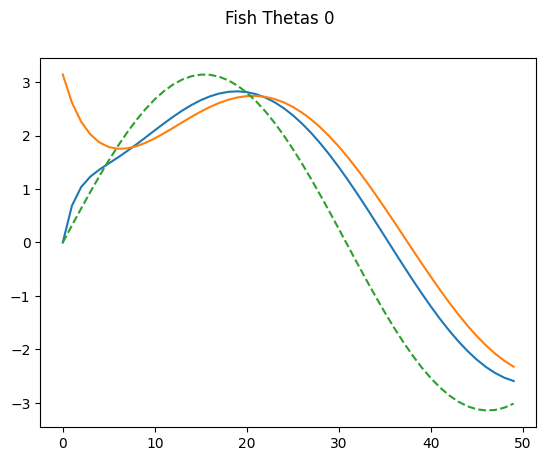

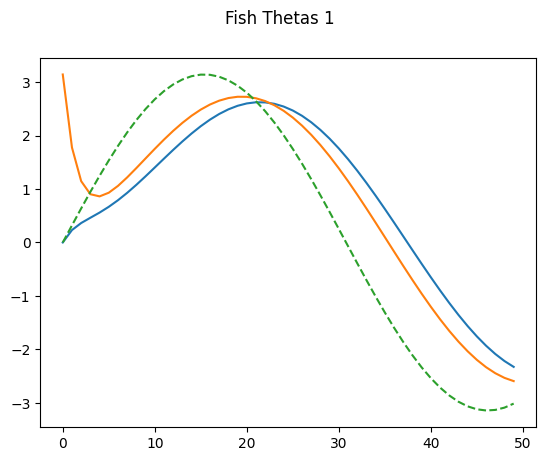

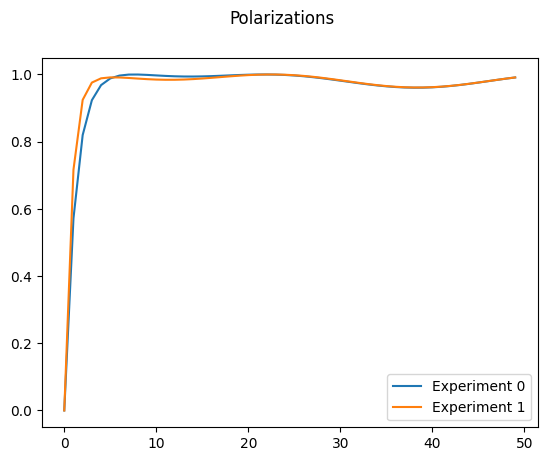

In [11]:
plot_experiments([traj31, traj13], [pol31, pol13])

In [12]:
# NO CHANGE
PosteriorMesh = namedtuple("PosteriorMesh", ["alpha", "beta", "log_prob"])

def likelihood_mesh_2fish(model, n=90):
    # Make a torch meshgrid of copy coefficients.
    alpha = torch.linspace(0., 7., n)
    beta = torch.linspace(0., 7., n)
    alpha, beta = torch.meshgrid(alpha, beta, indexing='xy')
    latents = torch.stack([alpha, beta], dim=0).reshape(2, -1).T  # .shape == (n^2, 2)
    
    log_probs = []
    for copy_coefs in latents:
        with pyro.poutine.trace() as tr:
            with condition(data=dict(copy_coefs=copy_coefs)):
                model()
        log_probs.append(tr.trace.log_prob_sum())
        print(f"Progress {len(log_probs)}/{latents.shape[0]}", end="\r")
    
    print()
    
    return PosteriorMesh(alpha, beta, torch.tensor(log_probs).reshape(n, n))

In [13]:
mesh31 = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol31}
    ),
    n=50
)

mesh13 = likelihood_mesh_2fish(
    condition(
        low_noise_experiment,
        data={"polarization": pol13}
    ),
    n=50
)

Progress 2500/2500
Progress 2500/2500


In [14]:
# NO CHANGE
def sample_from_mesh(mesh, num_samples, noise=0.05):
    xy = torch.stack([mesh.alpha, mesh.beta], dim=0).reshape(2, -1)
    probs = torch.softmax(mesh.log_prob.reshape(-1) - mesh.log_prob.max(), dim=0)
    idxs = torch.multinomial(probs, num_samples, replacement=True)
    return xy[:, idxs].T + torch.randn_like(xy[:, idxs].T) * noise

In [15]:
samples_31 = sample_from_mesh(mesh31, 1000)
samples_13 = sample_from_mesh(mesh13, 1000)

In [16]:
# NO CHANGE
XLIM = (0., 7.)
YLIM = (0., 7.)

(0.0, 7.0)

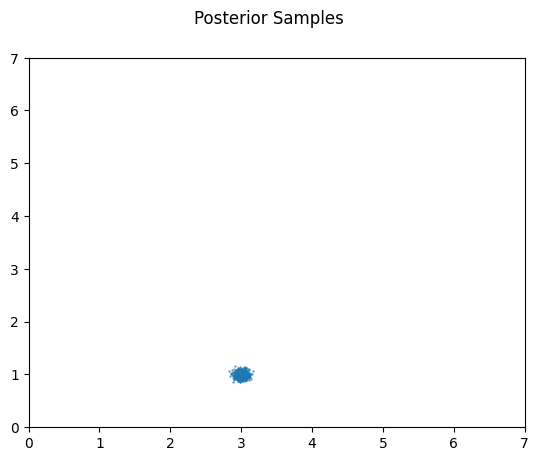

In [17]:
plt.figure()
plt.suptitle("Posterior Samples")
plt.scatter(samples_31[:, 0], samples_31[:, 1], label="3, 1", s=0.2)
plt.xlim(*XLIM)
plt.ylim(*YLIM)

(0.0, 7.0)

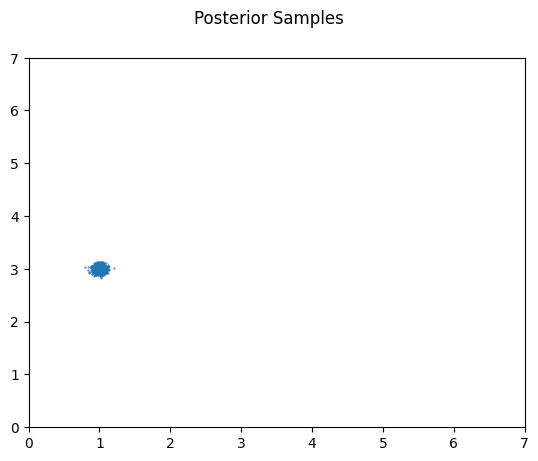

In [18]:
plt.figure()
plt.suptitle("Posterior Samples")
plt.scatter(samples_13[:, 0], samples_13[:, 1], label="1, 3", s=0.2)
plt.xlim(*XLIM)
plt.ylim(*YLIM)
